# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from string import punctuation
import nltk
from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
import string

sw = stopwords.words("english")

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [8]:
data_location = "/Users/mirnaphilip/Desktop/Applied_Text_Minning/m2/M1_Results/lyrics"

# Initialize an empty DataFrame
lyrics_data = pd.DataFrame(columns=['artist', 'song', 'lyrics'])

# Read the lyrics data into the DataFrame
for artist_folder in os.listdir(data_location):
    artist_path = os.path.join(data_location, artist_folder)
    if os.path.isdir(artist_path):
        for song_file in os.listdir(artist_path):
            song_path = os.path.join(artist_path, song_file)
            if os.path.isfile(song_path):  # Ensure it's a file
                with open(song_path, 'r') as file:
                    lyrics = file.read()
                    song_title = os.path.splitext(song_file)[0]
                    new_row = pd.DataFrame({'artist': [artist_folder], 'song': [song_title], 'lyrics': [lyrics]})
                    lyrics_data = pd.concat([lyrics_data, new_row], ignore_index=True)

# Display the DataFrame
lyrics_data.head()


,artist,song,lyrics
0,robyn,robyn_includemeout,"""Include Me Out""\n\n\n\nIt is really very simp..."
1,robyn,robyn_electric,"""Electric""\n\n\n\nElectric...\n\nIt's electric..."
2,robyn,robyn_beach2k20,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow..."
3,robyn,robyn_lovekills,"""Love Kills""\n\n\n\nIf you're looking for love..."
4,robyn,robyn_timemachine,"""Time Machine""\n\n\n\nHey, what did I do?\nCan..."


In [9]:
# Read in the twitter data
twitter_path = "/Users/mirnaphilip/Desktop/Applied_Text_Minning/m2/M1_Results/twitter/"

# Define artist files
artist_files = {
    'cher': 'cher_followers_data.txt',
    'robyn': 'robynkonichiwa_followers_data.txt'
}

# Function to read Twitter data into a dataframe
def read_twitter_data(twitter_path, artist_files):
    all_twitter_data = pd.DataFrame()
    
    for artist, file_name in artist_files.items():
        file_path = os.path.join(twitter_path, file_name)
        artist_data = pd.read_csv(file_path, sep="\t", quoting=3)
        artist_data['artist'] = artist
        all_twitter_data = pd.concat([all_twitter_data, artist_data], ignore_index=True)
    
    return all_twitter_data

# Read the Twitter data
twitter_data = read_twitter_data(twitter_path, artist_files)

# Display the first few rows of the Twitter data
print(twitter_data.head())


    screen_name          name                   id        location  \
0        hsmcnp  Country Girl             35152213             NaN   
1    horrormomy          Jeny   742153090850164742           Earth   
2  anju79990584          anju  1496463006451974150             NaN   
3  gallionjenna             J           3366479914             NaN   
4       bcscomm       bcscomm             83915043  Washington, DC   

   followers_count  friends_count  \
0             1302           1014   
1               81            514   
2               13            140   
3              752            556   
4              888           2891   

                                         description artist  
0                                                NaN   cher  
1           𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜   cher  
2          163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡   cher  
3                                                csu   cher  
4  Writer @Washinformer @SpelmanCollege alumna

In [10]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
# Read in the positive and negative words and the tidytext sentiment

# Define file paths for positive, negative, and tidytext sentiment words
positive_words_file = "/Users/mirnaphilip/Desktop/Applied_Text_Minning/m6/positive-words.txt"
negative_words_file = "/Users/mirnaphilip/Desktop/Applied_Text_Minning/m6/negative-words.txt"
tidytext_file = "/Users/mirnaphilip/Desktop/Applied_Text_Minning/m6/tidytext_sentiments.txt"


In [11]:
# Function to read sentiment words from a file and associate them with a score
def read_sentiment_words(file_path, score):
    with open(file_path, 'r', encoding='utf-8') as file:
        words = file.read().splitlines()
    return {word: score for word in words if word and not word.startswith(';')}

# Read the positive and negative words
positive_words = read_sentiment_words(positive_words_file, 1)
negative_words = read_sentiment_words(negative_words_file, -1)

# Combine positive and negative words into a single dictionary
sentiment_words = {**positive_words, **negative_words}

# Read the tidytext sentiments into a dataframe
tidytext_sentiments = pd.read_csv(tidytext_file, delimiter='\t', header=None, names=['word', 'sentiment'])

# Assign scores to tidytext sentiments
tidytext_sentiments['score'] = tidytext_sentiments['sentiment'].apply(lambda x: 1 if x == 'positive' else -1)

# Combine all sentiments into a single dictionary
tidytext_dict = dict(zip(tidytext_sentiments['word'], tidytext_sentiments['score']))

# Merge all dictionaries
all_sentiments = {**sentiment_words, **tidytext_dict}

# Convert to DataFrame for display
sentiment_df = pd.DataFrame(list(all_sentiments.items()), columns=['word', 'score'])

# Display the first few rows of the sentiment DataFrame
print(sentiment_df.head())

        word  score
0         a+      1
1     abound      1
2    abounds      1
3  abundance      1
4   abundant      1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [12]:

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def clean_and_tokenize(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words and word not in punctuation]
    return tokens

# Apply the function to the lyrics data
lyrics_data['cleaned_lyrics'] = lyrics_data['lyrics'].apply(clean_and_tokenize)

# Function to calculate sentiment score
def calculate_sentiment(tokens, lexicon):
    score = 0
    for token in tokens:
        score += lexicon.get(token, 0)
    return score

# Calculate sentiment score for each song
lyrics_data['sentiment_score'] = lyrics_data['cleaned_lyrics'].apply(lambda tokens: calculate_sentiment(tokens, all_sentiments))

# Average sentiment per artist
average_sentiment_per_artist = lyrics_data.groupby('artist')['sentiment_score'].mean()
print("Average sentiment per artist:")
print(average_sentiment_per_artist)

# Determine which artist has the higher average sentiment
highest_average_sentiment_artist = average_sentiment_per_artist.idxmax()
print(f"The artist with the highest average sentiment per song is: {highest_average_sentiment_artist}")

# Find the three highest and lowest sentiment songs for each artist
def find_extreme_songs(artist, num_songs=3):
    artist_data = lyrics_data[lyrics_data['artist'] == artist]
    highest_sentiment_songs = artist_data.nlargest(num_songs, 'sentiment_score')
    lowest_sentiment_songs = artist_data.nsmallest(num_songs, 'sentiment_score')
    return highest_sentiment_songs, lowest_sentiment_songs

# Example for one artist
artist = 'robyn'  # Replace with the desired artist
highest_songs, lowest_songs = find_extreme_songs(artist)
print(f"Three songs with the highest sentiment scores for {artist}:")
print(highest_songs[['song', 'sentiment_score']])
print(f"Three songs with the lowest sentiment scores for {artist}:")
print(lowest_songs[['song', 'sentiment_score']])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mirnaphilip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mirnaphilip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Average sentiment per artist:
artist
cher     3.468354
robyn    2.423077
Name: sentiment_score, dtype: float64
The artist with the highest average sentiment per song is: cher
Three songs with the highest sentiment scores for robyn:
                             song  sentiment_score
21               robyn_loveisfree              102
65  robyn_ushouldknowbetter114529               26
68        robyn_ushouldknowbetter               26
Three songs with the lowest sentiment scores for robyn:
                                     song  sentiment_score
53        robyn_dontfuckingtellmewhattodo              -77
75  robyn_dontfuckingtellmewhattodo114520              -77
16                   robyn_criminalintent              -53


### Questions

Q: Overall, which artist has the higher average sentiment per song? 


In [17]:
# Determine which artist has the higher average sentiment
highest_average_sentiment_artist = average_sentiment_per_artist.idxmax()
highest_average_sentiment_artist


'cher'

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

In [18]:
# Find the three highest and lowest sentiment songs for the first artist
artist = 'robyn'  # First artist
highest_songs, lowest_songs = find_extreme_songs(artist)
print(f"Three songs with the highest sentiment scores for {artist}:")
print(highest_songs[['song', 'sentiment_score', 'lyrics']])
print(f"Three songs with the lowest sentiment scores for {artist}:")
print(lowest_songs[['song', 'sentiment_score', 'lyrics']])


Three songs with the highest sentiment scores for robyn:
                             song  sentiment_score  \
21               robyn_loveisfree              102   
65  robyn_ushouldknowbetter114529               26   
68        robyn_ushouldknowbetter               26   

                                               lyrics  
21  "Love Is Free"\n\n\n\nFree\nLove is free, baby...  
65  "U Should Know Better"\n\n\n\nI've gone around...  
68  "U Should Know Better"\n\n\n\nI've gone around...  
Three songs with the lowest sentiment scores for robyn:
                                     song  sentiment_score  \
53        robyn_dontfuckingtellmewhattodo              -77   
75  robyn_dontfuckingtellmewhattodo114520              -77   
16                   robyn_criminalintent              -53   

                                               lyrics  
53  "Don't Fucking Tell Me What To Do"\n\n\n\nMy d...  
75  "Don't Fucking Tell Me What To Do"\n\n\n\nMy d...  
16  "Criminal Intent"\n\n\n\n

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

In [19]:
# Find the three highest and lowest sentiment songs for the second artist
artist = 'cher'  # Second artist
highest_songs, lowest_songs = find_extreme_songs(artist)
print(f"Three songs with the highest sentiment scores for {artist}:")
print(highest_songs[['song', 'sentiment_score', 'lyrics']])
print(f"Three songs with the lowest sentiment scores for {artist}:")
print(lowest_songs[['song', 'sentiment_score', 'lyrics']])


Three songs with the highest sentiment scores for cher:
                          song  sentiment_score  \
207            cher_perfection               48   
119                cher_mylove               46   
250  cher_loveandunderstanding               44   

                                                lyrics  
207  "Perfection"\n\n\n\nHush little Baby, gotta be...  
119  "My Love"\n\n\n\nWhen I go away\nI know my hea...  
250  "Love And Understanding"\n\n\n\nHere, here in ...  
Three songs with the lowest sentiment scores for cher:
                             song  sentiment_score  \
275  cher_iwalkonguildedsplinters              -25   
262               cher_outrageous              -24   
283          cher_whenyouwalkaway              -17   

                                                lyrics  
275  "I Walk On Guilded Splinters"\n\n\n\nSome peop...  
262  "Outrageous"\n\n\n\nOutrageous, outrageous\n(T...  
283  "When You Walk Away"\n\n\n\nSo leave if you're...  


Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

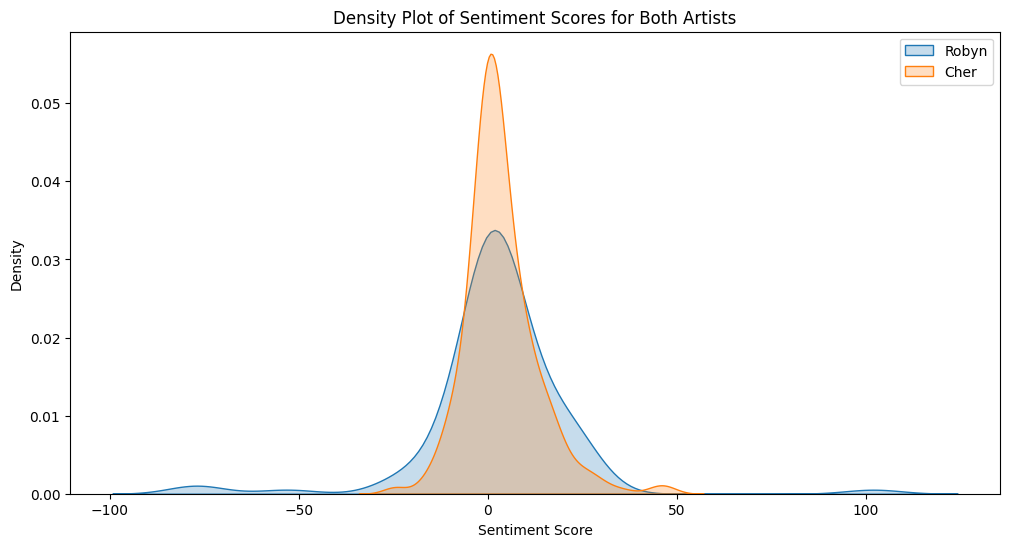

In [15]:
# Plot the distribution of sentiment scores for both artists
plt.figure(figsize=(12, 6))

# Density plot for Robyn
sns.kdeplot(data=lyrics_data[lyrics_data['artist'] == 'robyn'], x='sentiment_score', label='Robyn', fill=True)

# Density plot for Cher
sns.kdeplot(data=lyrics_data[lyrics_data['artist'] == 'cher'], x='sentiment_score', label='Cher', fill=True)

plt.title('Density Plot of Sentiment Scores for Both Artists')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [20]:
# your code here
# Define positive and negative emojis
positive_emojis = {
    "😀", "😃", "😄", "😁", "😊", "😇", "😍", "🥰", "😎", "👍"
}

negative_emojis = {
    "😞", "😠", "😡", "😢", "😭", "😩", "😤", "👎", "😓", "💔"
}

# Associate these emojis with scores
emoji_sentiments = {emoji: 1 for emoji in positive_emojis}
emoji_sentiments.update({emoji: -1 for emoji in negative_emojis})


In [22]:
import emoji

# Function to extract emojis from text
def extract_emojis(text):
    return [char for char in str(text) if char in emoji.EMOJI_DATA]

# Apply the function to extract emojis
twitter_data['emojis'] = twitter_data['description'].apply(extract_emojis)


In [23]:
# Function to calculate emoji sentiment score
def calculate_emoji_sentiment(emojis):
    score = 0
    for em in emojis:
        score += emoji_sentiments.get(em, 0)
    return score

# Calculate emoji sentiment score for each description
twitter_data['emoji_sentiment_score'] = twitter_data['emojis'].apply(calculate_emoji_sentiment)


In [24]:
# Calculate the average sentiment score for each artist
average_sentiment_per_artist = twitter_data.groupby('artist')['emoji_sentiment_score'].mean()
print("Average emoji sentiment per artist:")
print(average_sentiment_per_artist)

# Determine which artist has the higher average emoji sentiment
highest_average_sentiment_artist = average_sentiment_per_artist.idxmax()
print(f"The artist with the highest average emoji sentiment per post is: {highest_average_sentiment_artist}")


Average emoji sentiment per artist:
artist
cher     0.007435
robyn    0.003215
Name: emoji_sentiment_score, dtype: float64
The artist with the highest average emoji sentiment per post is: cher


Q: What is the average sentiment of your two artists? 

A: The average sentiment of cher was  0.007435 and  Robyn was  0.003215

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: For Cher, the most popular positive emoji is 😍 (heart eyes), and the most popular negative emoji is 😢 (crying face).
For Robyn, the most popular positive emoji is 😊 (smiling face with smiling eyes), and the most popular negative emoji is 😞 (disappointed face).



In [25]:
# Function to count emojis
def count_emojis(emojis):
    return pd.Series(emojis).value_counts()

# Count emojis for each artist
emoji_counts = twitter_data.groupby('artist')['emojis'].sum().apply(count_emojis)

# Separate positive and negative emojis
def get_most_popular_emojis(emoji_counts, positive_emojis, negative_emojis):
    positive_counts = emoji_counts[emoji_counts.index.isin(positive_emojis)]
    negative_counts = emoji_counts[emoji_counts.index.isin(negative_emojis)]
    most_popular_positive = positive_counts.idxmax() if not positive_counts.empty else None
    most_popular_negative = negative_counts.idxmax() if not negative_counts.empty else None
    return most_popular_positive, most_popular_negative

# Get the most popular emojis for each artist
most_popular_emojis = {}
for artist, counts in emoji_counts.items():
    most_popular_emojis[artist] = get_most_popular_emojis(counts, positive_emojis, negative_emojis)

# Display the results
for artist, (pos_emoji, neg_emoji) in most_popular_emojis.items():
    print(f"Artist: {artist}")
    print(f"Most popular positive emoji: {pos_emoji}")
    print(f"Most popular negative emoji: {neg_emoji}\n")
